# Mesh refinement

In [1]:
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline
from matplotlib import animation
from IPython.display import HTML

## Newtonian, 1d, single layer

In [93]:
# set gravity
g = 1.
gamma = 5./3.

# define grids
nx = 500
nt = 2000
ng = 2
xmin = 0.
xmax = 10.
r = 2 # refinement ratio
cfl = 0.1
df = 0.4 # size of fine grid as a fraction of coarse grid size
rho = 1.

# coarse grid
xc = np.linspace(xmin, xmax, num=nx, endpoint=False) # values of x at boundaries
qc = np.zeros((nt+1, nx, 2))
dxc = xc[1] - xc[0]
dtc = cfl * dxc
# now shift to centres
xc += 0.5 * dxc

# fine grid for inner quarter
xf = np.linspace(0.5*(1.-df)*(xmax-xmin)+xmin, 0.5*(1.+df)*(xmax-xmin)+xmin, num=int(r*df*nx), endpoint=False)
qf = np.zeros((nt+1, int(r*df*nx), 3))
dxf = xf[1] - xf[0]
dtf = cfl * dxf
# now shift to centres
xf += 0.5 * dxf

dt = min(dtc, r*dtf) # dt for coarse grid - fine grid subcycles r times per coarse timestep

print('dxc: {}, dxf: {}'.format(dxc, dxf))
#print(xc)
#print(xf)

# indices in coarse grid of cells at start of fine grid and right of end of fine grid
matching_indices = [int(np.ceil(nx*0.5*(1-df))), int(np.ceil(nx*0.5*(1+df)))]
print(matching_indices, xc[matching_indices[0]], xf[0], xc[matching_indices[1]], xf[-1])

dxc: 0.02, dxf: 0.009999999999999787
[150, 350] 3.01 3.005 7.01 6.995


In [94]:
def bcs(grid):
    # outflow boundary conditions 
    grid[:ng,:] = grid[ng,:]
    grid[-ng:,:] = grid[-ng-1,:]

In [95]:
# Start off with an initial water hill
qc[0,:,0] = 1. + 0.4 * np.exp(-(xc-5.)**2*2) #0.01 * np.sin(0.25 * np.pi + 2. * np.pi * x / (xmax - xmin)) + 1.
bcs(qc[0,:,:])
#print(qc[0,:])

In [49]:
def phi(r):
    #ph = np.zeros_like(r)
    
    # MC limiter 
    return np.maximum(0.0, np.minimum(1,2.*r), np.minimum(2., r))
    # superbee limiter is not symmetric?
    """for i, rr in enumerate(r):
        if rr >= 1.:
            ph[i] = np.minimum(2., np.minimum(rr, 2./(1.+rr)))
        elif rr >= 0.5:
            ph[i] = 1.
        elif rr > 0:
            ph[i] = 2. * rr
        else:
            ph[i] = 0.
    return ph"""
        
def prolong(q_c, q_f):
    # coarse to fine 
    
    # first convert from SWE conserved variables to compressible conserved variables 
    # (h, hu) -> (rho, rho u, E)
    qc_comp = np.zeros((nx, 3))
    qc_comp[:,0] = rho
    qc_comp[:,1] = rho * q_c[:,1] / q_c[:,0]
    qc_comp[:,2] = 0.5 * rho * (g * q_c[:,0]**2 / (gamma - 1.) + q_c[:,1]**2/q_c[:,0]**2)
    
    # need to use slope limited upwinding to predict

    for s, c in enumerate(range(matching_indices[0], matching_indices[1])):
        # average slope
        S_upwind = (qc_comp[c+1,:] - qc_comp[c,:])  /dxc
        S_downwind = (qc_comp[c,:] - qc_comp[c-1,:]) / dxc
        S = 0.5 * (S_upwind + S_downwind)
        # ratio of slopes
        r = np.ones_like(S) * 1.e6
        r[np.abs(S_downwind) > 1.e-10] = S_upwind[np.abs(S_downwind) > 1.e-10] / S_downwind[np.abs(S_downwind) > 1.e-10]
        # limit the slope
        S *= phi(r)
        
        q_f[2*s,:] = qc_comp[c,:] - 0.25 * dxc * S
        q_f[2*s+1,:] = qc_comp[c,:] + 0.25 * dxc * S
    
    
def restrict(q_c, q_f):
    # fine to coarse
    
    # first convert from compressible conserved variables to SWE conserved variables
    # (rho, rho u, E) -> (h, hu)
    qf_sw = np.zeros((len(q_f[:,0]), 2))
    qf_sw[:,0] = np.sqrt(2. * (gamma - 1.) * (q_f[:,2] - 0.5 * q_f[:,1]**2 / q_f[:,0]) / (q_f[:,0] * g))
    qf_sw[:,1] = qf_sw[:,0] * q_f[:,1] / q_f[:,0]
    
    # don't copy back the outermost 2 cells - treat these as ghost cells
    for f, c in enumerate(range(matching_indices[0]+1, matching_indices[1]-1)):
        # just use simple averaging
        q_c[c,:] = 0.5 * (qf_sw[(f+1)*2,:] + qf_sw[(f+1)*2+1,:])

In [92]:
def evolve(q, flux_func, dx):
    
    # shallow water 

    q_p = np.zeros_like(q[1:-1,:])
    q_m = np.zeros_like(q[1:-1,:])
    
    f_p = np.zeros_like(q[1:-1,:])
    f_m = np.zeros_like(q[1:-1,:])
    
    S_upwind = (q[2:,:] - q[1:-1]) / dx
    S_downwind = (q[1:-1] - q[:-2,:]) / dx
    S = 0.5 * (S_upwind + S_downwind)
    #print(S)
    r = np.ones_like(S) * 1.e6
    r[np.abs(S_downwind) > 1.e-10] = S_upwind[np.abs(S_downwind) > 1.e-10] / S_downwind[np.abs(S_downwind) > 1.e-10]
    ph = np.zeros_like(r)
    for i in range(len(ph[:,0])):
        ph[i,:] = phi(r[i,:])
    S *= ph
    #print(S)
    
    q_p = q[1:-1,:] + S * 0.5 * dx
    q_m = q[1:-1,:] - S * 0.5 * dx
    
    #print(qc_p)
    
    # calculate fluxes at boundaries
    f_p = flux_func(q_p)
    
    f_m = flux_func(q_m)
    
    alpha = cfl * dx / dt
    
    # Lax-Friedrichs flux
    F_m = 0.5 * (f_p[:-2,:] + f_m[1:-1,:] + alpha * (q_p[:-2,:] - q_m[1:-1,:]))
    F_p = 0.5 * (f_p[1:-1,:] + f_m[2:,:] + alpha * (q_p[1:-1,:] - q_m[2:,:]))
    
    F = np.zeros_like(q)
    
    F[2:-2,:] = -alpha * (F_p - F_m) / dx
    
    #if flux_func == shallow_water_fluxes:
    bcs(F)
    
    return F

In [83]:
def shallow_water_fluxes(q):
    # f = (hu, hu**2 + 0.5*g*h**2)
    f = np.zeros_like(q)
    f[:,0] = q[:,1]
    f[:,1] = q[:,1]**2 / q[:,0] + 0.5 * g * q[:,0]**2
    
    return f

def compressible_fluxes(q):
    # f = (rho*u, rho*u**2 + p, (E+p)*u)
    f = np.zeros_like(q)
    p = (gamma - 1.) * (q[:,2] - 0.5 * q[:,1]**2 / q[:,0])
    f[:,0] = q[:,1]
    f[:,1] = q[:,1]**2 / q[:,0] + p
    f[:,2] = (q[:,2] + p) * q[:,1] / q[:,0]
    
    return f

In [52]:
def rk3(q, d_t, flux_func, dx):
    # third order runge-kutta
    F = evolve(q[:,:], flux_func, dx)
    
    q_temp = q[:,:] + d_t * F
    
    F = evolve(q_temp, flux_func, dx)
    
    q_temp = 0.25 * (3. * q[:,:] + q_temp + d_t * F)
    
    F = evolve(q_temp, flux_func, dx)
    
    return (q[:,:] + 2. * q_temp + 2. * d_t * F) / 3.

In [96]:
prolong(qc[0,:,:], qf[0,:,:])

for t in range(nt):
    
    # prolong to fine grid 
    prolong(qc[t,:,:], qf[t+1,:,:])
    
    # evolve fine grid through 2 subcycles 
    for i in range(r):
        qf[t+1,:,:] = rk3(qf[t+1,:,:], dt/r, compressible_fluxes, dxf)
        
    # restrict to coarse grid 
    qc[t+1,:,:] = qc[t,:,:]
    restrict(qc[t+1,:,:], qf[t+1,:,:])
    
    # evolve coarse grid
    #qc[t+1,:,:] = qc[t,:,:]
    qc[t+1,:,:] = rk3(qc[t+1,:,:], dt, shallow_water_fluxes, dxc)

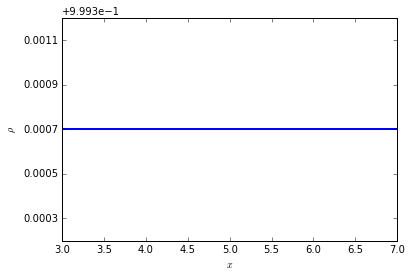

In [97]:
fig = plt.figure()
ax = plt.axes(xlim=(3,7), ylim=(0.9995, 1.0005))#xlim=(0,10)), ylim=(1.,1.4))
plt.xlabel(r'$x$')
plt.ylabel(r'$\rho$')
line = ax.plot([],[], lw=2)[0]

def animate(i):
    line.set_data(xf, qf[i*10,:,0])
    #return line

anim = animation.FuncAnimation(fig, animate, frames=int(nt/10), interval=25)#, blit=True)

In [98]:
HTML(anim.to_html5_video())

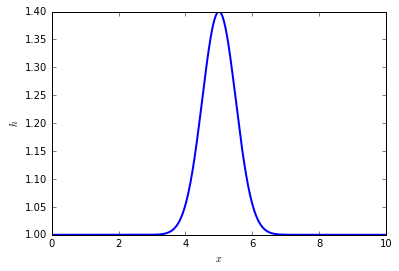

In [99]:
#for t in range(nt):
#    qc[t+1,:,:] = qc[t,:,:]
#    restrict(qc[t+1,:,:], qf[t+1,:,:])

fig = plt.figure()
ax = plt.axes(xlim=(0,10), ylim=(1.,1.4))
plt.xlabel(r'$x$')
plt.ylabel(r'$h$')
line = ax.plot([],[], lw=2)[0]

def animate(i):
    line.set_data(xc, qc[i*10,:,0])
    #return line

anim = animation.FuncAnimation(fig, animate, frames=int(nt/10), interval=25)#, blit=True)

In [100]:
HTML(anim.to_html5_video())

In [505]:
# check prolong and restrict work
prolong(qc[0,:,:], qf[0,:,:])
print(qc[0,:,:])
print(qf[0,:,:])
restrict(qc[0,:,:], qf[0,:,:])
print(qc[0,:,:])
print(qf[0,:,:])

[[ 1.          0.        ]
 [ 1.          0.        ]
 [ 1.          0.        ]
 [ 1.          0.        ]
 [ 1.          0.        ]
 [ 1.          0.        ]
 [ 1.          0.        ]
 [ 1.          0.        ]
 [ 1.          0.        ]
 [ 1.          0.        ]
 [ 1.          0.        ]
 [ 1.          0.        ]
 [ 1.          0.        ]
 [ 1.          0.        ]
 [ 1.          0.        ]
 [ 1.          0.        ]
 [ 1.          0.        ]
 [ 1.          0.        ]
 [ 1.          0.        ]
 [ 1.          0.        ]
 [ 1.          0.        ]
 [ 1.          0.        ]
 [ 1.          0.        ]
 [ 1.          0.        ]
 [ 1.          0.        ]
 [ 1.          0.        ]
 [ 1.          0.        ]
 [ 1.          0.        ]
 [ 1.          0.        ]
 [ 1.          0.        ]
 [ 1.          0.        ]
 [ 1.          0.        ]
 [ 1.          0.        ]
 [ 1.          0.        ]
 [ 1.          0.        ]
 [ 1.          0.        ]
 [ 1.          0.        ]
 